# Trabalho Final - INF 493

> Alunos: Cleber Luiz Oliveira Junior, Vinicius Kuster Lodi


#IMPORTS IMPORTANTES

In [1]:
# Imports iniciais:

!pip install scikit-optimize catboost xgboost

import pandas as pd
import matplotlib as mtplt
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss, jaccard_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
import shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


# Treinamento do modelo

## Separação da base

In [2]:
base = pd.read_excel("basePosProcessamento2500Normalizada.xlsx")

In [3]:
semente = 42

y = base['OBITO']
X = base.drop(columns=['OBITO'])

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)


Shape de X: (2486, 17)
Shape de y: (2486,)


### Avaliação final do catboost

>  Realizada usando validação cruzada com toda a base e com 75% da base para validação/treino e 25% de teste

In [4]:
print("\n===============================================")
print("AVALIAÇÃO FINAL DO MODELO CATBOOST")
print("===============================================\n")

best_catboost_params = OrderedDict({'bagging_temperature': 0.0,
                                    'border_count': 32,
                                    'depth': 6,
                                    'iterations': 500,
                                    'l2_leaf_reg': 1.0,
                                    'learning_rate': 0.015179469923665884,
                                    'scale_pos_weight': 1.0})

# Inicializa CatBoost com os melhores parametros encontrados
final_catboost_model = CatBoostClassifier(
    random_state=semente,
    verbose=0,
    thread_count=-1,
    **best_catboost_params
)

# Usa validação cruzada
rskf_final_evaluation = RepeatedStratifiedKFold(
    n_splits=10,
    n_repeats=30,
    random_state=semente
)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

print(f"Avaliando CatBoost com parâmetros ajustados...")

for train_index, test_index in rskf_final_evaluation.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = clone(final_catboost_model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))

final_catboost_results = {
    'Accuracy': {'mean': np.mean(accuracy_scores), 'std': np.std(accuracy_scores)},
    'Precision': {'mean': np.mean(precision_scores), 'std': np.std(precision_scores)},
    'Recall': {'mean': np.mean(recall_scores), 'std': np.std(recall_scores)},
    'F1-Score': {'mean': np.mean(f1_scores), 'std': np.std(f1_scores)},
    'ROC AUC': {'mean': np.nanmean(roc_auc_scores), 'std': np.nanstd(roc_auc_scores)}
}

print("\n\nRESULTADOS FINAIS (CATBOOST – MÉDIA ± DESVIO - CV 10x30):")
print(f"--- CatBoost ---")
for metric_name, values in final_catboost_results.items():
    print(f"{metric_name}: {values['mean']:.4f} \u00b1 {values['std']:.4f}")



AVALIAÇÃO FINAL DO MODELO CATBOOST

Avaliando CatBoost com parâmetros ajustados...


RESULTADOS FINAIS (CATBOOST – MÉDIA ± DESVIO - CV 10x30):
--- CatBoost ---
Accuracy: 0.9054 ± 0.0165
Precision: 0.9392 ± 0.0244
Recall: 0.8148 ± 0.0365
F1-Score: 0.8720 ± 0.0240
ROC AUC: 0.9501 ± 0.0139


In [5]:
print("\n==========================================================")
print("AVALIAÇÃO FINAL DO MODELO CATBOOST (75% TREINO & 25% TESTE)")
print("============================================================\n")

best_catboost_params = OrderedDict({'bagging_temperature': 0.0,
                                    'border_count': 32,
                                    'depth': 6,
                                    'iterations': 500,
                                    'l2_leaf_reg': 1.0,
                                    'learning_rate': 0.015179469923665884,
                                    'scale_pos_weight': 1.0})

# Inicializar o CatBoost com os melhores parâmetros
final_catboost_model = CatBoostClassifier(
    random_state=semente,
    verbose=0,
    thread_count=-1,
    **best_catboost_params
)

# 1. Dividir os dados em conjuntos de treino/validação (75%) e teste final (25%)
X_train_val, X_test_final, y_train_val, y_test_final = train_test_split(
    X, y, test_size=0.25, random_state=semente, stratify=y
)

# Reutilizar a validação cruzada para o conjunto de treino/validação
rskf_evaluation_on_train_val = RepeatedStratifiedKFold(
    n_splits=10,
    n_repeats=30,
    random_state=semente
)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

print(f"Avaliando CatBoost com parâmetros ajustados no conjunto de treino/validação (75% dos dados) via validação cruzada...")

# A validação cruzada agora será aplicada apenas em X_train_val e y_train_val
for train_index, val_index in rskf_evaluation_on_train_val.split(X_train_val, y_train_val):
    X_train_fold, X_val_fold = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train_fold, y_val_fold = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    model = clone(final_catboost_model)
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    y_proba = model.predict_proba(X_val_fold)[:, 1]

    accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
    precision_scores.append(precision_score(y_val_fold, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_val_fold, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_val_fold, y_pred, zero_division=0))
    roc_auc_scores.append(roc_auc_score(y_val_fold, y_proba))

cross_validation_results = {
    'Accuracy': {'mean': np.mean(accuracy_scores), 'std': np.std(accuracy_scores)},
    'Precision': {'mean': np.mean(precision_scores), 'std': np.std(precision_scores)},
    'Recall': {'mean': np.mean(recall_scores), 'std': np.std(recall_scores)},
    'F1-Score': {'mean': np.mean(f1_scores), 'std': np.std(f1_scores)},
    'ROC AUC': {'mean': np.nanmean(roc_auc_scores), 'std': np.nanstd(roc_auc_scores)}
}

print("\n\nRESULTADOS DA VALIDAÇÃO CRUZADA (CATBOOST – MÉDIA \u00b1 DESVIO - CV 10x30 no conjunto de treino/validação):")
print(f"--- CatBoost ---")
for metric_name, values in cross_validation_results.items():
    print(f"{metric_name}: {values['mean']:.4f} \u00b1 {values['std']:.4f}")

# 2. Treinar o modelo final no X_train_val completo e avaliar no X_test_final
print(f"\n\nTreinando o modelo final no conjunto de treino/validação completo e avaliando no conjunto de teste final (25% dos dados)...")
final_model_trained = clone(final_catboost_model)
final_model_trained.fit(X_train_val, y_train_val)
y_pred_final_test = final_model_trained.predict(X_test_final)
y_proba_final_test = final_model_trained.predict_proba(X_test_final)[:, 1]

final_test_results = {
    'Accuracy': accuracy_score(y_test_final, y_pred_final_test),
    'Precision': precision_score(y_test_final, y_pred_final_test, zero_division=0),
    'Recall': recall_score(y_test_final, y_pred_final_test, zero_division=0),
    'F1-Score': f1_score(y_test_final, y_pred_final_test, zero_division=0),
    'ROC AUC': roc_auc_score(y_test_final, y_proba_final_test)
}

print("\n\nRESULTADOS DA AVALIAÇÃO NO CONJUNTO DE TESTE FINAL (25% dos dados):")
print(f"--- CatBoost ---")
for metric_name, value in final_test_results.items():
    print(f"{metric_name}: {value:.4f}")



AVALIAÇÃO FINAL DO MODELO CATBOOST (75% TREINO & 25% TESTE)

Avaliando CatBoost com parâmetros ajustados no conjunto de treino/validação (75% dos dados) via validação cruzada...


RESULTADOS DA VALIDAÇÃO CRUZADA (CATBOOST – MÉDIA ± DESVIO - CV 10x30 no conjunto de treino/validação):
--- CatBoost ---
Accuracy: 0.9017 ± 0.0197
Precision: 0.9333 ± 0.0306
Recall: 0.8109 ± 0.0432
F1-Score: 0.8669 ± 0.0281
ROC AUC: 0.9499 ± 0.0165


Treinando o modelo final no conjunto de treino/validação completo e avaliando no conjunto de teste final (25% dos dados)...


RESULTADOS DA AVALIAÇÃO NO CONJUNTO DE TESTE FINAL (25% dos dados):
--- CatBoost ---
Accuracy: 0.9116
Precision: 0.9660
Recall: 0.8057
F1-Score: 0.8786
ROC AUC: 0.9473


# Métricas de Avaliação do Modelo

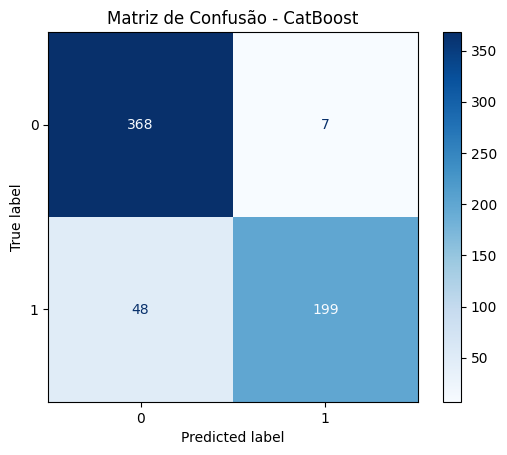

In [6]:
# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final_test)

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test_final,
    y_pred=y_pred_final_test,
    cmap=plt.cm.Blues
)

disp.ax_.set_title('Matriz de Confusão - CatBoost')
plt.savefig('matriz_confusao.png')
plt.show()

In [7]:
TN = np.sum((y_test_final == y_pred_final_test) & (y_test_final == 0))
FP = np.sum((y_test_final != y_pred_final_test) & (y_pred_final_test == 1))

specificity = TN / (FP + TN)

# Hamming Loss
hammingloss = hamming_loss(y_test_final, y_pred_final_test)

# Jaccard Score
jaccard = jaccard_score(y_test_final, y_pred_final_test, zero_division=0)

# Calculando a eficiência
recall = final_test_results['Recall']
eficiencia = (recall + specificity) / 2.0

print("\n===============================================")
print("Métricas Detalhadas - CatBoost (Conjunto de Teste Final)")
print("===============================================\n")

print(f"Accuracy: {final_test_results['Accuracy']:.4f}")
print(f"Precision: {final_test_results['Precision']:.4f}")
print(f"Recall: {final_test_results['Recall']:.4f}")
print(f"F1-Score: {final_test_results['F1-Score']:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"Eficiência: {eficiencia:.4f}")
print(f"Hamming Loss: {hammingloss:.4f}")
print(f"Jaccard Score: {jaccard:.4f}")


Métricas Detalhadas - CatBoost (Conjunto de Teste Final)

Accuracy: 0.9116
Precision: 0.9660
Recall: 0.8057
F1-Score: 0.8786
Especificidade: 0.9813
Eficiência: 0.8935
Hamming Loss: 0.0884
Jaccard Score: 0.7835


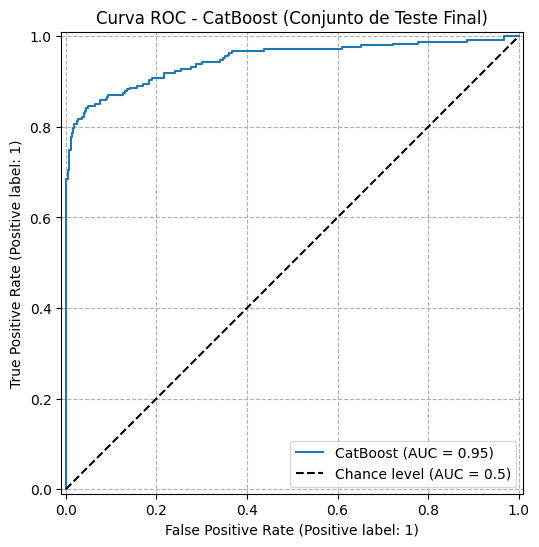


ROC AUC Score (CatBoost - Conjunto de Teste Final): 0.9473


In [8]:
# ROC AUC
fig, ax = plt.subplots(figsize=(8, 6))
roc_disp = RocCurveDisplay.from_predictions(
    y_true=y_test_final,
    y_pred=y_proba_final_test,
    name='CatBoost',
    ax=ax,
    plot_chance_level=True
)

ax.set_title('Curva ROC - CatBoost (Conjunto de Teste Final)')
ax.grid(linestyle='--')
plt.savefig('curva_roc_auc.png')
plt.show()

roc_auc = roc_auc_score(y_test_final, y_proba_final_test)
print(f"\nROC AUC Score (CatBoost - Conjunto de Teste Final): {roc_auc:.4f}")

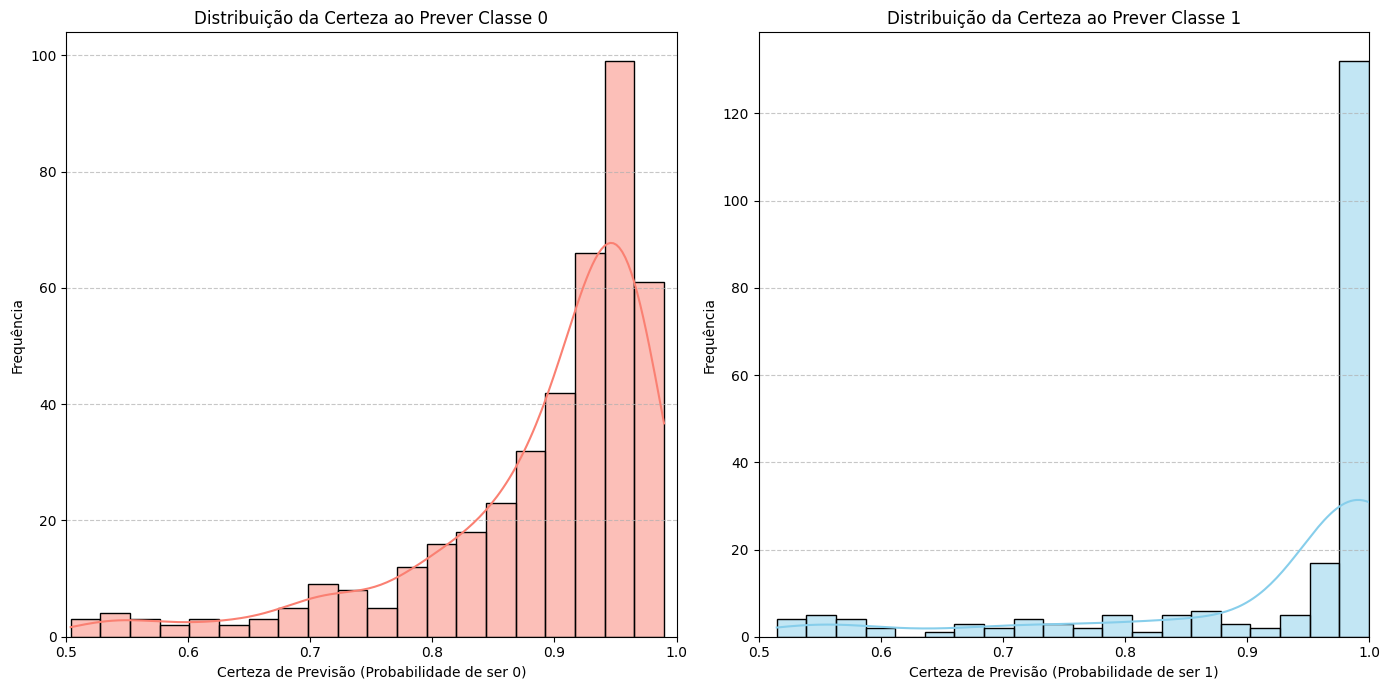

In [14]:
y_pred_final_test_series = pd.Series(y_pred_final_test)

# Filtrar probabilidades para as previsões da classe 0 e calcular a certeza para 0
certainty_pred_0 = 1 - y_proba_final_test[y_pred_final_test_series == 0]

# Filtrar probabilidades para as previsões da classe 1 (a certeza já é a própria probabilidade)
certainty_pred_1 = y_proba_final_test[y_pred_final_test_series == 1]

plt.figure(figsize=(14, 7))

# Histograma para certeza na previsão de 0
plt.subplot(1, 2, 1) # 1 linha, 2 colunas, 1º gráfico
sns.histplot(certainty_pred_0, bins=20, kde=True, color='salmon')
plt.title('Distribuição da Certeza ao Prever Classe 0')
plt.xlabel('Certeza de Previsão (Probabilidade de ser 0)')
plt.ylabel('Frequência')
plt.xlim(0.5, 1.0) # Certeza para 0 deve ser maior que 0.5
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Histograma para certeza na previsão de 1
plt.subplot(1, 2, 2) # 1 linha, 2 colunas, 2º gráfico
sns.histplot(certainty_pred_1, bins=20, kde=True, color='skyblue')
plt.title('Distribuição da Certeza ao Prever Classe 1')
plt.xlabel('Certeza de Previsão (Probabilidade de ser 1)')
plt.ylabel('Frequência')
plt.xlim(0.5, 1.0) # Certeza para 1 deve ser maior que 0.5
plt.savefig("Distribuição.png")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Explicabilidade do modelo


Global SHAP Feature Importance - Summary Plot



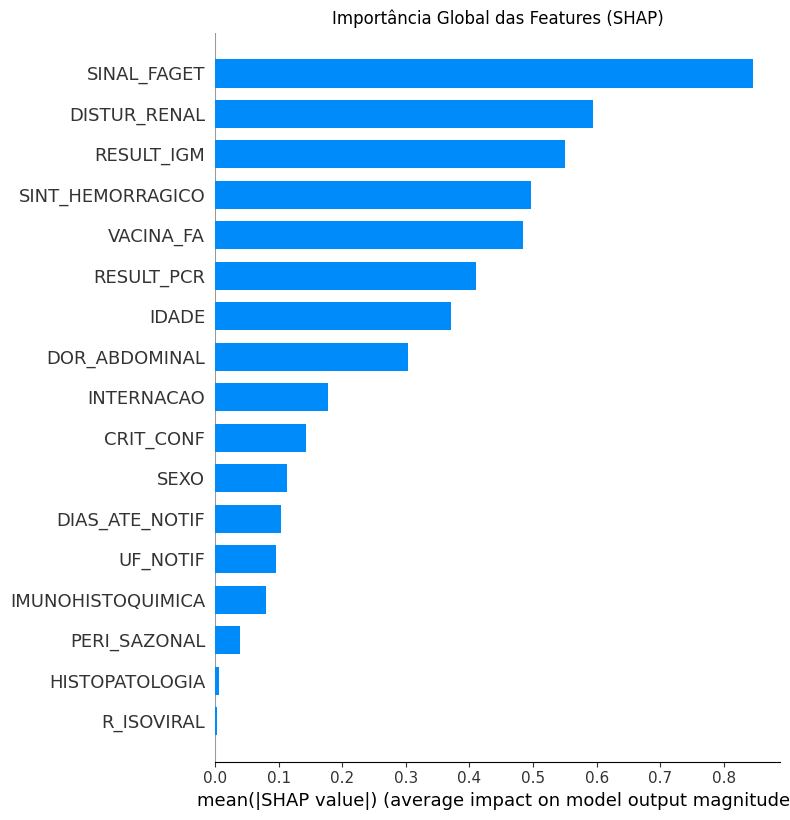

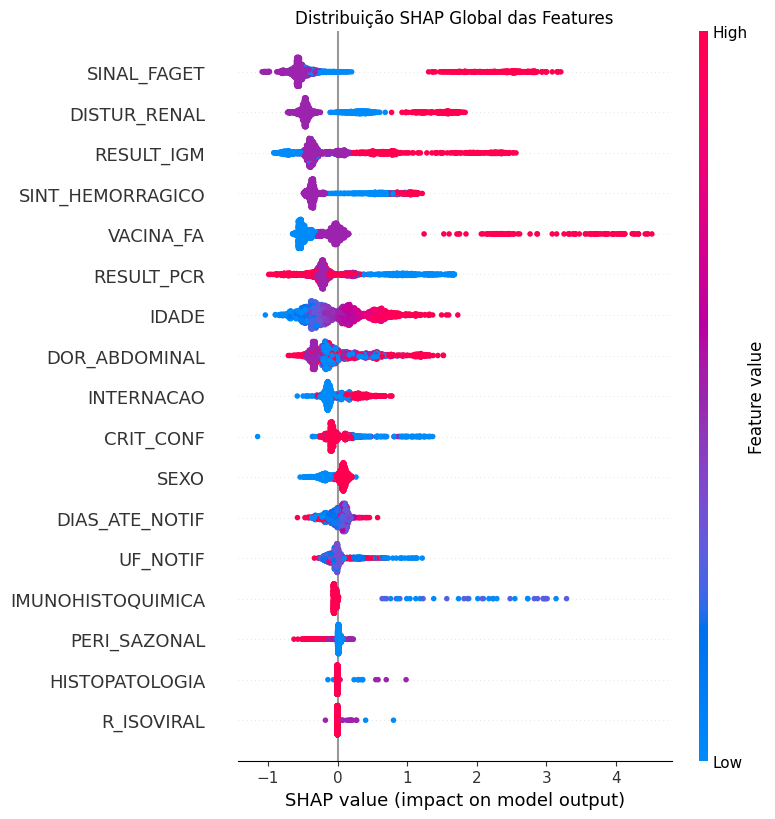

In [12]:
# Usamos X_train_val porque é o conjunto de dados em que o modelo foi treinado antes da avaliação final no conjunto de teste.
explainer = shap.TreeExplainer(final_model_trained)

# Calcular os valores SHAP para o conjunto de treinamento/validação
shap_values = explainer.shap_values(X_train_val)

# Plotar o summary plot global
print("\n===============================================")
print("Global SHAP Feature Importance - Summary Plot")
print("===============================================\n")
shap.summary_plot(shap_values, X_train_val, plot_type="bar", show=False)
plt.title('Importância Global das Features (SHAP)')
plt.tight_layout()
plt.savefig('shap_global_summary_bar.png')
plt.show()

shap.summary_plot(shap_values, X_train_val, show=False)
plt.title('Distribuição SHAP Global das Features')
plt.tight_layout()
plt.savefig('shap_global_summary_dot.png')
plt.show()